<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 254kB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 952kB 37.4MB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [2]:
# Download bdataset
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/bdataset_stereo.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [3]:
!git pull
!python dataset.py
!python model.py

Already up to date.
dataset ok
model ok


In [3]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.01
BETAS = [0.9, 0.999]
EPS = 0.00000001
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
DAMPENING = 0.1

MILESTONES = [10,20,30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [4]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

test_transform = A.Compose(
    [
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

detect_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)

images = LoadImages(IMAGES, transform=detect_transform)


In [5]:
model = Model()
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=LEARNING_RATE, betas=BETAS, 
                          eps=EPS, weight_decay=WEIGHT_DECAY)
# solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
#                          lr=LEARNING_RATE, momentum=MOMENTUM,
#                          dampening = DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()
metric_fn = MetricFunction(BATCH_SIZE)

In [6]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    train_one_epoch(model, train_dataloader, loss_fn, solver, epoch_idx)
    lr_scheduler.step()

100%|██████████| 27/27 [00:34<00:00,  1.26s/it, epoch=39, loss=(total:0.1141 depth:0.04538474977016449 normal:0.06874426454305649)]


In [7]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 14/14 [00:08<00:00,  1.57it/s]

eval_avg_error
Epoch: 39, loss=(total:0.1412 depth:0.03655923902988434 normal:0.10464340448379517)
======DEPTH=======
MSE=0.0077	RMSE=0.0870	MAE=0.0355	ABS_REL=0.0794
DELTA1.02=0.6734	DELTA1.05=0.7237	DELTA1.10=0.7748
DELTA1.25=0.8755	DELTA1.25^2=0.9644	DELTA1.25^3=0.9890
======NORMALS=======
MSE=0.5643	RMSE=0.7505	MAE=0.7191	MME=0.7229
TANGLE11.25=0.0511	TANGLE22.5=0.0674	TANGLE30.0=0.0901



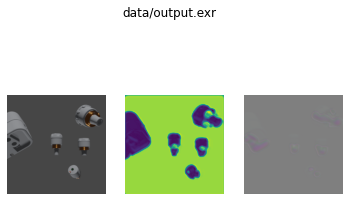

In [9]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
for images, predictions, path in generatePredictions(model, images):
    plot_predictions(images, predictions, [path])

In [10]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)